<a href="https://colab.research.google.com/github/Batista94/nlp_disaster_tweets_kaggle/blob/main/analise_sentimento_git_integrado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Sentimento em Tweets sobre Desastres


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## importação das bibliotecas e definição de semente aleatória

In [2]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 72.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1


In [3]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import time

In [4]:
#Definição de semente aleatória para consistencia nos experimentos
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Configuração do dispositivo (GPU se disponível, caso contrário CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Pré processamento dos dados

In [5]:
#Leitura dos dados de treinos 'crus'
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/files_analise_sentimento/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Modificação do df para colunas que interessam
train_df_new = train_df[['text', 'target']]
train_df_new.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Remoção de palavras sem significado semântico real
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    text = text.lower()

    doc = nlp(text)

    cleaned_tokens = [
        token.lemma_ for token in doc
        if not token.is_punct
        and not token.is_space
        and not token.is_stop
        and not token.like_url
        and not token.like_email
        and token.is_alpha
        and len(token.text) > 2
    ]

    cleaned_text = " ".join(cleaned_tokens)
    return cleaned_text


In [8]:
treated_phrases = list()
for review in train_df['text']:
    new_phrase = preprocess_text(review)
    treated_phrases.append(new_phrase)
#Criando nova coluna no df
train_df.loc[:, 'treated_text'] = treated_phrases


## Criando novo df, removendo os tweets que podem ter ficado sem palavras

train_df['treated_text_length'] = train_df['treated_text'].fillna('').apply(len)
train_df_cleaned = train_df[train_df['treated_text_length'] > 0].reset_index(drop=True)
treated_train_df = train_df_cleaned[['target', 'treated_text']]

In [9]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

Essa classe "TextClassificationDataset" faz o seguinte:

Recebe os textos, rótulos, o tokenizador do DistilBERT e o comprimento máximo dos tweets (128 tokens é um bom padrão, mas caso seus textos sejam maiores, você pode alterá-lo).
O método len retorna o número total de amostras.
O método getitem retorna uma amostra individual. Ele tokeniza o texto usando o tokenizador do DistilBERT, adiciona tokens especiais (como [CLS] no início e [SEP] no final), limita o comprimento do tweet ao max_length e preenche com tokens de padding se necessário. Ele também retorna uma máscara de atenção, que indica quais tokens são reais e quais são padding. Finalmente, ele retorna os IDs dos tokens, a máscara de atenção e o rótulo como tensores PyTorch.

### Treino e testes

In [10]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Divisao de treino e testes

train_texts, val_texts, train_labels, val_labels = train_test_split(
    treated_train_df['treated_text'].values,
    treated_train_df['target'].values,
    test_size=0.2,
    random_state=SEED
)

# Criação dataset

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [11]:
#Criação de dataloaders para carregamento de dados em lotes (batch)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [12]:
#Criação de rede neural recebendo modelo DistilBERT e as 2 classes para classificação, devido as possíveis respotas de desastre e não desastre

transformer = DistilBertModel.from_pretrained('distilbert-base-uncased')

class TransformerClassifier(nn.Module):
    def __init__(self, transformer_model,n_classes):
        super().__init__()
        self.transformer = transformer_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

model = TransformerClassifier(transformer, n_classes=2)
model = model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [13]:
def train_model(model, train_loader, val_loader, device, nn_type, num_epochs):
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    # Calculo do total de etapas de treinamento para o agendadorscheduler
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    train_losses, valid_losses, train_accus, valid_accus = [], [], [], []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')

        # fase de treino
        start_train = time.time()
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0

        for batch in tqdm(train_loader, desc='Training'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = train_correct / train_total
        end_train = time.time()

        # Validacao
        start_eval = time.time()
        model.eval()
        total_val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        end_eval = time.time()

        # Armazenamento de perdas e precisoes para plotar
        train_losses.append(total_train_loss/len(train_loader))
        valid_losses.append(total_val_loss/len(val_loader))
        train_accus.append(train_accuracy)
        valid_accus.append(val_accuracy)

        # Comparacao valid_acc com best_val_acc
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            # Salvar  state_dict do modelo
            torch.save(model.state_dict(), f"best_model_{nn_type}.pt")

        print(f"Train Loss: {total_train_loss/len(train_loader):.4f} | Train Acc: {train_accuracy * 100:.2f}% | Time: {end_train-start_train:.2f}s")
        print(f"Valid Loss: {total_val_loss/len(val_loader):.4f} | Valid Acc: {val_accuracy * 100:.2f}% | Time: {end_eval-start_eval:.2f}s")

    print(f"\nThe best {nn_type.upper()} model was had an accuracy of {best_val_acc * 100:.2f}%")

    return num_epochs, train_losses, valid_losses, train_accus, valid_accus

In [14]:
num_epochs = 10

results_distilbert = train_model(model, train_loader, val_loader, device, "distilbert", num_epochs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.4713 | Train Acc: 79.11% | Time: 67.19s
Valid Loss: 0.4101 | Valid Acc: 81.99% | Time: 5.60s

Epoch 2/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.3585 | Train Acc: 85.67% | Time: 67.00s
Valid Loss: 0.4235 | Valid Acc: 81.99% | Time: 5.80s

Epoch 3/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.2780 | Train Acc: 89.55% | Time: 68.88s
Valid Loss: 0.5475 | Valid Acc: 80.41% | Time: 5.78s

Epoch 4/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.2033 | Train Acc: 92.80% | Time: 67.06s
Valid Loss: 0.7477 | Valid Acc: 79.55% | Time: 5.78s

Epoch 5/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1529 | Train Acc: 94.67% | Time: 66.97s
Valid Loss: 0.8197 | Valid Acc: 80.41% | Time: 5.74s

Epoch 6/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1171 | Train Acc: 96.10% | Time: 66.98s
Valid Loss: 1.0011 | Valid Acc: 80.34% | Time: 5.70s

Epoch 7/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0947 | Train Acc: 97.06% | Time: 66.95s
Valid Loss: 1.1348 | Valid Acc: 80.14% | Time: 5.74s

Epoch 8/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0764 | Train Acc: 97.58% | Time: 67.05s
Valid Loss: 1.1940 | Valid Acc: 79.88% | Time: 5.68s

Epoch 9/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0662 | Train Acc: 98.01% | Time: 66.97s
Valid Loss: 1.2439 | Valid Acc: 79.88% | Time: 5.72s

Epoch 10/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0556 | Train Acc: 98.19% | Time: 67.03s
Valid Loss: 1.2782 | Valid Acc: 79.82% | Time: 5.69s

The best DISTILBERT model was had an accuracy of 81.99%


###Plotando curvas de aprendizado

Transformers - DistilBERT


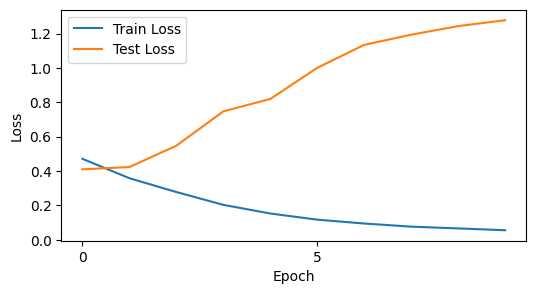

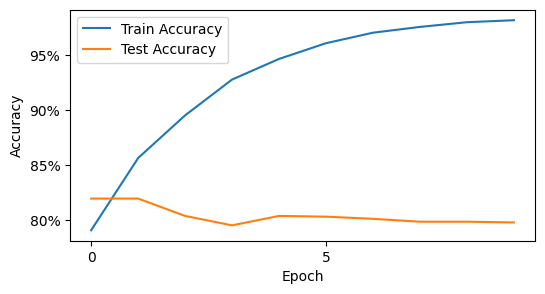

In [21]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_curves(N_EPOCHS, train_losses, valid_losses, train_accus, valid_accus):
    # Plot Loss Curves
    plt.figure(figsize=(6,3))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Test Loss')
    plt.xticks(range(0, N_EPOCHS, 5))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # Plot Accuracy Curves
    plt.figure(figsize=(6,3))
    plt.plot(train_accus, label='Train Accuracy')
    plt.plot(valid_accus, label='Test Accuracy')
    plt.xticks(range(0, N_EPOCHS, 5))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{val * 100:.0f}%"))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

print('Transformers - DistilBERT')
plot_curves(results_distilbert[0], results_distilbert[1], results_distilbert[2],
            results_distilbert[3], results_distilbert[4])